 #### We looked for interesting ways in which word counts relate to ratings.

In [3]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm


data = pd.read_csv("../data/drugsComTrain_top_conditions.csv")
data_test = pd.read_csv("../data/drugsComTest_top_conditions.csv")

# 

#data = pd.read_csv("../data/drugsComTrain_tokens.csv")
#data_test = pd.read_csv("../data/drugsComTest_tokens.csv")

#### Before extracting word tokens we filter out punctuation marks and "stop words", words occurring frequently in any text like "and", "the", ... 

In [4]:
from nltk.corpus import stopwords
#nltk.download("stopwords")
import re

s=set(stopwords.words('english'))
s.add("i'm")
s.add('like')
s.add("I've")
s.add('mg')

# Filters )(!- additionally compared to 4
def filter_the_review(review):
    # remove ""
    review = re.sub('\"', '', review)
    
    # replace &#39; -> this is equivlaent to '
    review = re.sub('&#039;', '\'', review)
    
    # remove .,; &quot
    review = re.sub('[.,;]', '', review)
    review = re.sub('&quot', '', review)
    
    #remove ) ( ! -
    #exclamation mark might be interesting, though
    review = re.sub('[)(!-]', '', review)
    
    
    # change to small letters
    review = review.lower()
    
    # remove numbers
    review = re.sub('[0-9]+','', review)
    
    # replace two spaces with one (if they exist somewhere)
    review = re.sub('  ', ' ', review)
    
    # remove the stopwords
    filtered = filter(lambda w: not w in s,review.split())
    
    list_words = list(filtered)
    string_review = " ".join(list_words)
    

    return string_review

In [5]:
data["review_t"] = data["review"].transform(lambda x: nltk.word_tokenize(filter_the_review(x)))
data_test["review_t"] = data_test["review"].transform(lambda x: nltk.word_tokenize(filter_the_review(x)))


review = data["review"].iloc[3]
print(review)
print(type(review))
tokens = data["review_t"].iloc[3]
print(tokens)
print(type(tokens))


"Suboxone has completely turned my life around.  I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account.  I had none of those before Suboxone and spent years abusing oxycontin.  My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction.  All that is history.  If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again.  I have found the side-effects to be minimal compared to oxycontin.  I&#039;m actually sleeping better.   Slight constipation is about it for me.  It truly is amazing. The cost pales in comparison to what I spent on oxycontin."
<class 'str'>
['suboxone', 'completely', 'turned', 'life', 'around', 'feel', 'healthier', 'excelling', 'job', 'always', 'money', 'pocket', 'savings', 'account', 'none', 'suboxone', 'spent', 'years', 'abusing', 'oxycontin', 'paycheck', 'already', 'spent', 'time', 'got', 'started',

In [6]:
#Earlier I saved the word tokens here.

#data.to_csv("../data/drugsComTrain_tokens.csv")
#data_test.to_csv("../data/drugsComTest_tokens.csv")
data.info()

### Look at most common words in positive/negative reviews to formulate hypothesis
### ...for specific drugs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129376 entries, 0 to 129375
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       129376 non-null  int64  
 1   uniqueID         129376 non-null  int64  
 2   drugName         129376 non-null  object 
 3   condition        128477 non-null  object 
 4   review           129376 non-null  object 
 5   rating           129376 non-null  int64  
 6   date             129376 non-null  object 
 7   usefulCount      129376 non-null  int64  
 8   condition_count  128477 non-null  float64
 9   review_t         129376 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 9.9+ MB


#### Utility function for extracting word frequencies in subset of data.

In [8]:
def get_freq_dist(df, conditions=False, ratings=range(1, 11)):
    filt_l = True
    if conditions:
        filt_l = (df["condition"].isin(conditions))
    df = df[filt_l & df["rating"].isin(ratings)]
    reviews = df["review_t"].sum()
    return nltk.FreqDist(reviews)


### We take a look at the unconditional distribution of ratings.

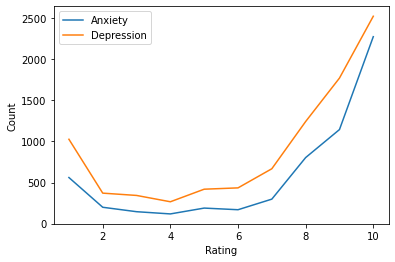

In [9]:
# Prediction of ratings depends on unconditional distribution of ratings
data_anx = data[data["condition"]=="Anxiety"]
data_depr = data[data["condition"]=="Depression"]
rating_counts_anx = [data_anx[data_anx["rating"]==i].shape[0] for i in range(1,11)]
rating_counts_depr = [data_depr[data_depr["rating"]==i].shape[0] for i in range(1,11)]

plt.plot(range(1,11), rating_counts_anx, label="Anxiety")
plt.plot(range(1,11), rating_counts_depr, label="Depression")
plt.legend()
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

#### We look for the most common words appearing in reviews of certain diseases.

In [10]:
# -> naively high and - to a lesser degree - lower ratings will be predicted preferentially

freq_dist_anx = get_freq_dist(data, ["Anxiety"])
freq_dist_depr = get_freq_dist(data, ["Depression"])

In [11]:
n = 50
#maybe compare randomly selected words as inputs vs most common words?
words_anx = [w for w, _ in freq_dist_anx.most_common(n)]
words_depr = [w for w, _ in freq_dist_depr.most_common(n)]

#### We extract bag of words vectors with corresponding ratings from dataset.

In [12]:
def get_count_vector(row, words):
    counts = [nltk.FreqDist(row["review_t"]).get(w) for w in words]
    counts = [0 if count is None else count for count in counts]
    return counts

# Collect word count vectors for words in df and corresponding ratings
def get_count_vectors(df, words, target_val = "rating"):
    word_vectors=[]
    target_vals=[]
    for _, row in df.iterrows():
        word_vectors.append(get_count_vector(row, words))
        target_vals.append(row[target_val])
    word_vectors = np.array(word_vectors)
    target_vals = np.array(target_vals)
    return word_vectors, target_vals

In [13]:
X_depr, y_depr = get_count_vectors(data_depr, words_depr)
print(X_depr)
print(y_depr)

[[1 1 2 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]]
[10  8  4 ... 10  3  2]


#### Quick look at predictions of linear classifier on small sample of dataset.

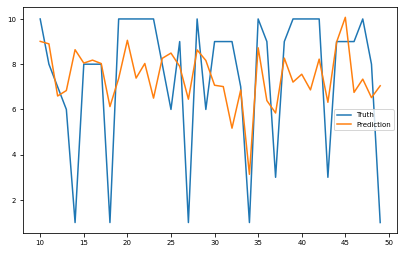

In [21]:
model_depr = LinearRegression().fit(X_depr, y_depr)
sample_nr = range(10, 50)
samples = [data_depr.iloc[i] for i in sample_nr]
inputs = [get_count_vector(sample, words_depr) for sample in samples]
true_labels = [sample["rating"] for sample in samples]
plt.plot(sample_nr, true_labels, label="Truth")
plt.plot(sample_nr, model_depr.predict(inputs), label="Prediction")
plt.legend()
plt.show()

In [28]:
counts_rating_word = []
for rating in range(1,11):
    freq_dist = get_freq_dist(data_depr, ratings=[rating])
    n = freq_dist.N()
    counts_rating_word.append([freq_dist.get(word)/n for word in words_depr])
counts_word_ratings = np.array(counts_rating_word).T
cor_coeffs = []
ratings = np.array(range(1,11))
for i in range(counts_word_ratings.shape[0]):
    x = np.vstack((counts_word_ratings[i], ratings))
    cor_coeffs.append(np.corrcoef(x))
cor_coeffs = [np.abs(cor_coeff[0,1]) for cor_coeff in cor_coeffs]

## Correlation of word counts and ratings for 50 most common words in a subset of the data.
#### Word counts divided by text length to make correlations more meaningful, displaying absolute value of Pearson correlation coefficient.

Text(0, 0.5, 'Pearson Correlation')

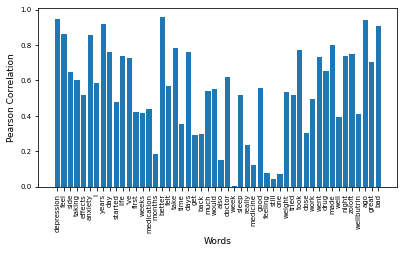

In [32]:
from tueplots import bundles
plt.rcParams.update(bundles.neurips2021(usetex=False, ncols=1, nrows=1))
plt.xticks(rotation=90)
plt.bar(words_depr, cor_coeffs)
plt.xlabel("Words")
plt.ylabel("Pearson Correlation")
#plt.savefig("../docs/pdfs/words_corr.pdf")

## Influence of additional word counts on performance of linear regression models.
#### Linear regression models are trained on the n most common words for n from 1 to 50, showing the nth word on the x-axis. R$^2$ score accounts for imbalance in prior distribution of ratings. R$^2$ of zero is the best constant model.

In [35]:
# Improvement of prediction with number of considered words
# Score used by sklearn mitigates issue of prior distribution of ratings
data_test_depr = data_test[data_test["condition"]=="Depression"]
X_test_depr, y_test_depr = get_count_vectors(data_test_depr, words_depr)
dim_inputs = range(1,51)
models_depr = [LinearRegression().fit(X_depr[:,:d], y_depr) for d in dim_inputs]
scores_test = [model.score(X_test_depr[:,:d], y_test_depr) for model, d in zip(models_depr, dim_inputs)]
scores_train = [model.score(X_depr[:,:d], y_depr) for model, d in zip(models_depr, dim_inputs)]

C:\Users\simon\AppData\Local\Temp/ipykernel_8860/1037022493.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(words_depr, rotation=90, size=6.2, fontweight="bold")
C:\Users\simon\AppData\Local\Temp/ipykernel_8860/1037022493.py:15: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


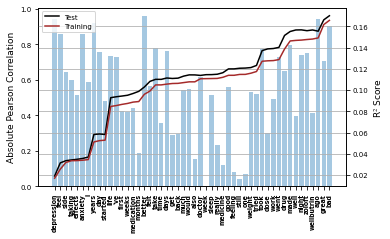

In [36]:
# Here we can somewhat see which words help more in predicting rating

plt.rcParams.update(bundles.neurips2021(usetex=False, ncols=1, nrows=1))
fig, ax1 = plt.subplots()
ax1.set_xticklabels(words_depr, rotation=90, size=6.2, fontweight="bold")
ax1.set_ylabel("Absolute Pearson Correlation")
ax1.bar(words_depr, cor_coeffs, alpha=0.4)

ax2 = ax1.twinx()

ax2.set_ylabel("R$^2$ Score")
ax2.plot(words_depr, scores_test, label="Test", c="black")
ax2.plot(words_depr, scores_train, label="Training", c="brown")

fig.tight_layout()

plt.legend()
plt.grid()
#plt.savefig("../docs/pdfs/score_corr_normalized.pdf")
plt.show()

#### The differences between scores is the importance of a word for prediction given the previous words.

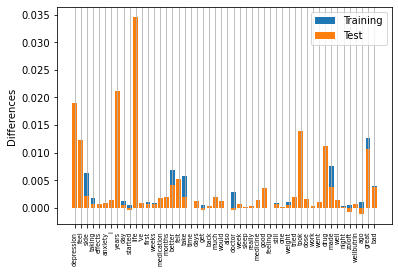

In [58]:
sns.reset_orig()
diffs_test = np.diff(scores_test, prepend=0)
diffs_train = np.diff(scores_train, prepend=0)

plt.xticks(rotation=90, size=6.2)
plt.bar(words_depr, diffs_train, label="Training")
plt.bar(words_depr, diffs_test, label="Test")
plt.ylabel("Differences")
plt.grid(axis="x")
plt.legend()
plt.show()


#### Utility function calculating the above scores given chosen words, dataframes and model.

In [59]:
def models_over_acc_inputs(words, df_train=None, df_test=None, matrices=None, regressor = LinearRegression, target_val="rating"):
    if matrices:
        X_train, y_train, X_test, y_test = matrices
    else:
        X_train, y_train = get_count_vectors(df_train, words, target_val=target_val)
        X_test, y_test = get_count_vectors(df_test, words, target_val=target_val)
    input_dims = range(1, len(words)+1)
    models = [regressor().fit(X_train[:,:d], y_train) for d in input_dims]
    scores_train = [model.score(X_train[:,:d], y_train) for model, d in zip(models, input_dims)]
    scores_test = [model.score(X_test[:,:d], y_test) for model, d in zip(models, input_dims)]
    return models, scores_train, scores_test

In [60]:
matrices = (X_depr, y_depr, X_test_depr, y_test_depr)
model_tree, scores_train_tree, scores_test_tree = models_over_acc_inputs(words_depr, matrices=matrices, regressor=DecisionTreeClassifier)


#### Looking at curve for a different ordering of inputs.

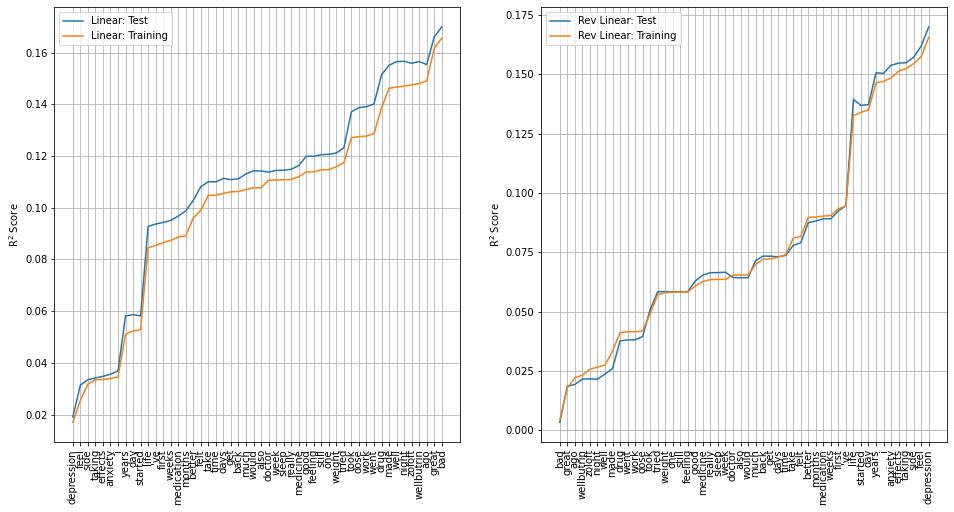

In [65]:
words_depr_rev = list(reversed(words_depr))
#_, scores_train_rev, scores_test_rev = models_over_acc_inputs(words_depr_rev, df_train=data_depr, df_test=data_test_depr)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
ax1.tick_params('x', labelrotation=90)
ax2.tick_params('x', labelrotation=90)

ax1.plot(words_depr, scores_test, label="Linear: Test")
ax1.plot(words_depr, scores_train, label="Linear: Training")
ax2.plot(words_depr_rev, scores_test_rev, label="Rev Linear: Test")
ax2.plot(words_depr_rev, scores_train_rev, label="Rev Linear: Training")

ax1.set_ylabel("R$^2$ Score")
ax2.set_ylabel("R$^2$ Score")
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()

plt.show()


## Comparing decision trees in the same way.
#### Performance also improves monotonously, but curves look concave, that is no word counts stick out as much more important than previous ones - this remains true for adding word counts in reverse order.

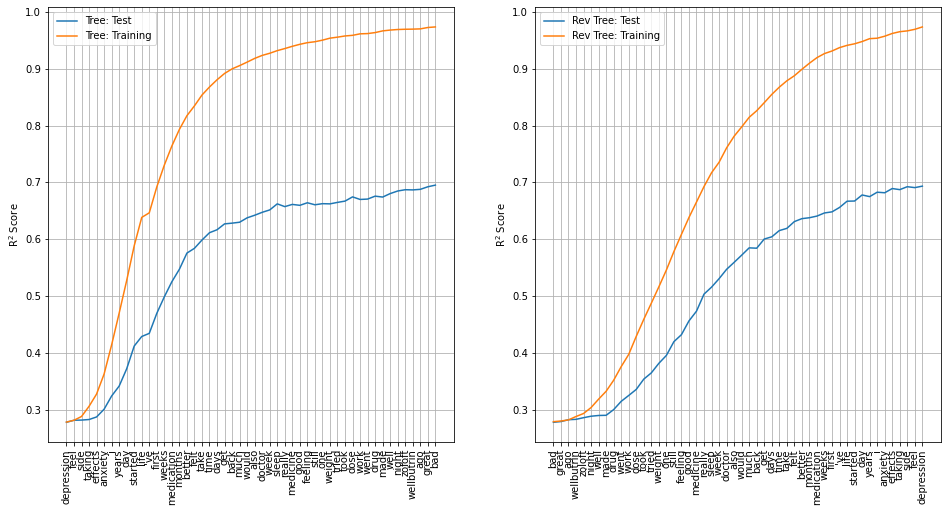

In [67]:
words_depr_rev = list(reversed(words_depr))
#_, scores_train_rev_tree, scores_test_rev_tree = models_over_acc_inputs(words_depr_rev, df_train=data_depr, df_test=data_test_depr, regressor=DecisionTreeClassifier)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
ax1.tick_params('x', labelrotation=90)
ax2.tick_params('x', labelrotation=90)

ax1.plot(words_depr, scores_test_tree, label="Tree: Test")
ax1.plot(words_depr, scores_train_tree, label="Tree: Training")
ax2.plot(words_depr_rev, scores_test_rev_tree, label="Rev Tree: Test")
ax2.plot(words_depr_rev, scores_train_rev_tree, label="Rev Tree: Training")

ax1.set_ylabel("R$^2$ Score")
ax2.set_ylabel("R$^2$ Score")
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()

#plt.savefig("../docs/pdfs/words_vs_score_dectree.pdf")

plt.show()


In [40]:
print(f"Final Decision Tree Test Score: {scores_test_tree[-1]}")
print(f"Final Decision Tree Training Score: {scores_train_tree[-1]}")

Final Decision Tree Test Score: 0.6930533117932148
Final Decision Tree Training Score: 0.9735362222957327


#### Unused utility function.

In [47]:
def word_count_matrix(df, n, conditions=None, drugs=None):
    
    filt_1 = True
    filt_2 = True
    if conditions:
        filt_1 = df["condition"].isin(conditions)
    if drugs:
        filt_2 = df["drugName"].isin(drugs)
    df = df[filt_1 & filt_2]
    freq_dict = nltk.FreqDist(df["review_t"].sum())
    n_most_common = [word for word, _ in freq_dict.most_common(n)]
    word_counts=[]
    ratings=[]
    for i in range(1, 11):
        word_counts.append([nltk.FreqDist(df[df["rating"]==i]["review_t"].sum()).get(key) for key in n_most_common])
    return word_counts, ratings, n_most_common